In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:

# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/drive/My Drive/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


In [0]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "binlogs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_cig_butts_0008.h5")


COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
print(MODEL_DIR )
print(COCO_MODEL_PATH)

/content/drive/My Drive/binlogs
/content/drive/My Drive/mask_rcnn_coco.h5


In [12]:
class Cervic_binary_classConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Cervic_binary_class"

    # Train on 1 GPU and 1 image per GPU. Batch sizoure is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500
    LEARNING_RATE= 5e-4
    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = Cervic_binary_classConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['category_id']
            # class_id = 4
            class_name = category['name']
            # class_name = 'Severe_dysplastic'
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['filename']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [0]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/drive/My Drive/bin_cervic_train/cervic_binary_class_train.json', '/content/drive/My Drive/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/drive/My Drive/bin_cervic_validation/cervic_binary_class_validation.json', '/content/drive/My Drive/')
dataset_val.prepare()

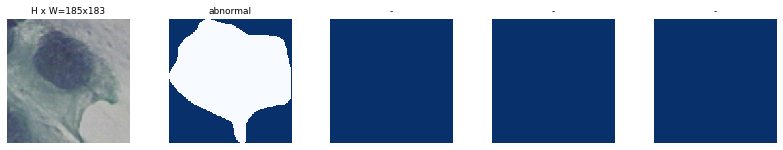

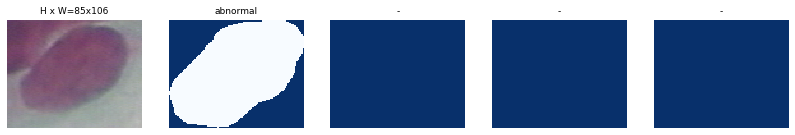

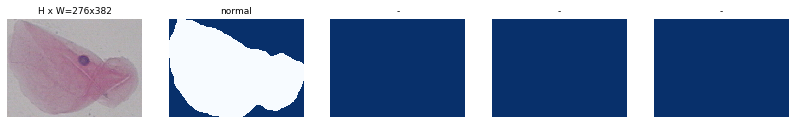

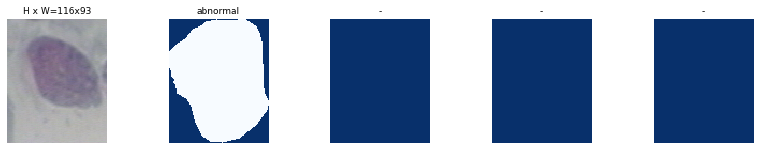

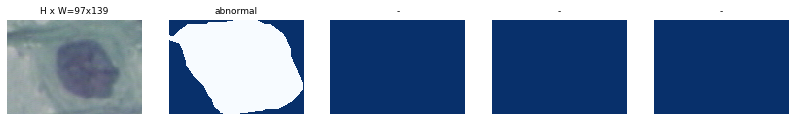

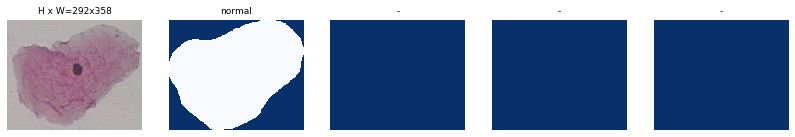

In [15]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids,6)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)


In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [17]:
# Which weights to start with?
# init_with = "coco"  # imagenet, coco, or last
init_with = "imagenet"
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

94658560/94653016 [==============================] - 2s 0us/step








In [18]:

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.0005

Checkpoint Path: /content/drive/My Drive/binlogs/cervic_binary_class20191231T0434/mask_rcnn_cervic_binary_class_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/20
500/500 [==============================] - 144s 289ms/step - loss: 3.2787 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 2.1068 - mrcnn_class_loss: 0.2010 - mrcnn_bbox_loss: 0.3422 - mrcnn_mask_loss: 0.5527 - val_loss: 2.4068 - val_rpn_class_loss: 0.0653 - val_rpn_bbox_loss: 1.6692 - val_mrcnn_class_loss: 0.0383 - val_mrcnn_bbox_loss: 0.1401 - val_mrcnn_mask_loss: 0.4940

Epoch 2/20
500/500 [==============================] - 110s 220ms/step - loss: 1.9118 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 1.1019 - mrcnn_class_loss: 0.1566 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.4391 - val_loss: 2.3172 - val_rpn_class_loss: 0.0371 - val_rpn_bbox_loss: 1.3132 - val_mrcnn_class_loss: 0.3264 - val_mrcnn_bbox_loss: 0.2189 - val_mrcnn_mask_loss: 0.4217
Epoch 3/20
500/500 [==============================] - 107s 215ms/step - loss: 1.3620 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.7431 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.3816 - val_loss: 1.3728 - val

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

# start_train = time.time()
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=8, 
#             layers="all")
# end_train = time.time()
# minutes = round((end_train - start_train) / 60, 2)
# print(f'Training took {minutes} minutes')

In [0]:
class InferenceConfig(Cervic_binary_classConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    # DETECTION_MIN_CONFIDENCE = 0.85
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

In [0]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/drive/My Drive/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [21]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR )



Instructions for updating:
Use `tf.cast` instead.


In [26]:


# Get path to saved weights

# Either set a specific path or find last trained weights
COCO_MODEL_PATH= '/content/drive/My Drive/binlogs/mask_rcnn_cervic_binary_class_0020.h5'
model_path = os.path.join(ROOT_DIR, COCO_MODEL_PATH )
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/binlogs/mask_rcnn_cervic_binary_class_0020.h5


filename:/content/drive/My Drive/bin_cervic_test/abnormal/149316426-149316462-001.BMP
Processing 1 images
image                    shape: (63, 58, 3)           min:   62.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



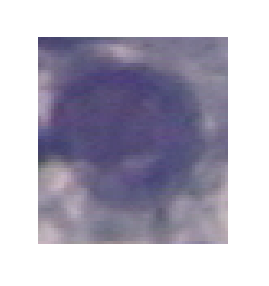

filename:/content/drive/My Drive/bin_cervic_test/abnormal/149316426-149316462-002.BMP
Processing 1 images
image                    shape: (63, 73, 3)           min:   74.00000  max:  202.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   97.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


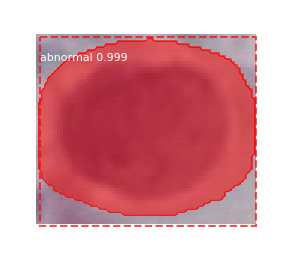

filename:/content/drive/My Drive/bin_cervic_test/abnormal/149316426-149316462-003.BMP
Processing 1 images
image                    shape: (71, 78, 3)           min:   61.00000  max:  211.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  103.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


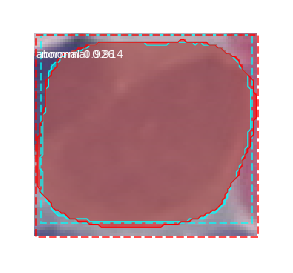

filename:/content/drive/My Drive/bin_cervic_test/abnormal/149316426-149316462-004.BMP
Processing 1 images
image                    shape: (43, 79, 3)           min:   76.00000  max:  200.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


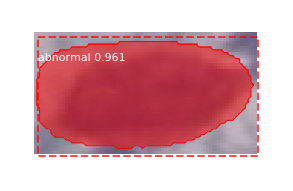

filename:/content/drive/My Drive/bin_cervic_test/abnormal/149317114-149317152-002.BMP
Processing 1 images
image                    shape: (77, 69, 3)           min:   51.00000  max:  216.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  105.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


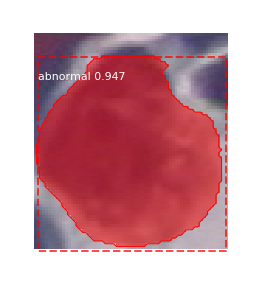

filename:/content/drive/My Drive/bin_cervic_test/abnormal/149317114-149317152-001.BMP
Processing 1 images
image                    shape: (62, 94, 3)           min:   58.00000  max:  210.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  104.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


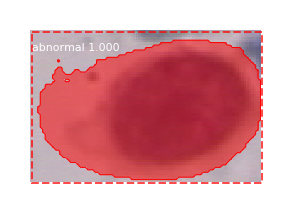

filename:/content/drive/My Drive/bin_cervic_test/abnormal/149317114-149317152-004.BMP
Processing 1 images
image                    shape: (60, 56, 3)           min:   53.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


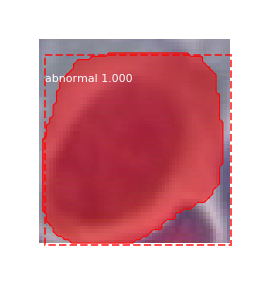

filename:/content/drive/My Drive/bin_cervic_test/abnormal/149357956-149358043-001.BMP
Processing 1 images
image                    shape: (96, 68, 3)           min:   42.00000  max:  196.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   79.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


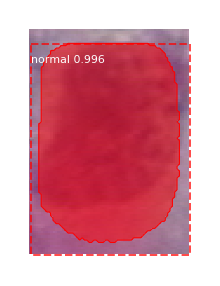

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153826597-153826619-001.BMP
Processing 1 images
image                    shape: (81, 70, 3)           min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



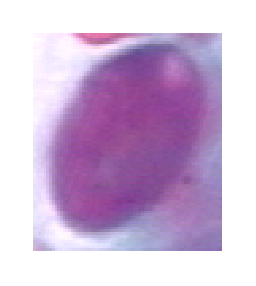

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153826597-153826619-002.BMP
Processing 1 images
image                    shape: (70, 112, 3)          min:   72.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


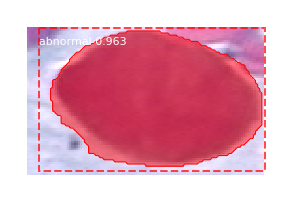

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153827595-153827657-001.BMP
Processing 1 images
image                    shape: (97, 65, 3)           min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


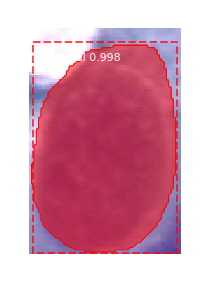

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153827595-153827657-002.BMP
Processing 1 images
image                    shape: (96, 68, 3)           min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


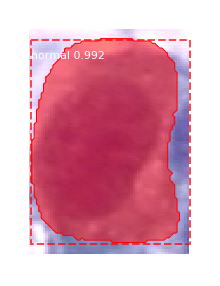

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153827595-153827664-001.BMP
Processing 1 images
image                    shape: (85, 75, 3)           min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


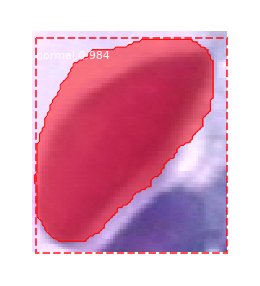

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153827595-153827669-001.BMP
Processing 1 images
image                    shape: (72, 54, 3)           min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


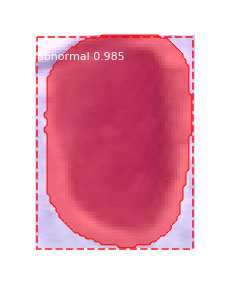

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153830680-153830693-001.BMP
Processing 1 images
image                    shape: (54, 86, 3)           min:   44.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


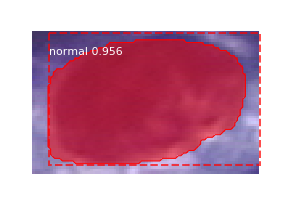

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831027-153831036-001.BMP
Processing 1 images
image                    shape: (85, 89, 3)           min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


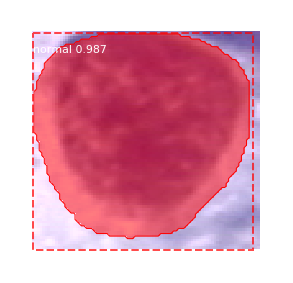

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831027-153831036-002.BMP
Processing 1 images
image                    shape: (66, 95, 3)           min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



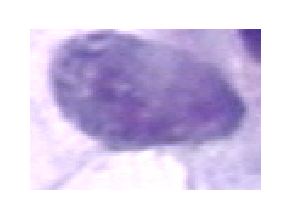

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831027-153831045-001.BMP
Processing 1 images
image                    shape: (81, 47, 3)           min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


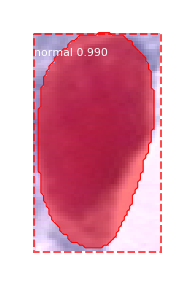

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831027-153831045-002.BMP
Processing 1 images
image                    shape: (70, 78, 3)           min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


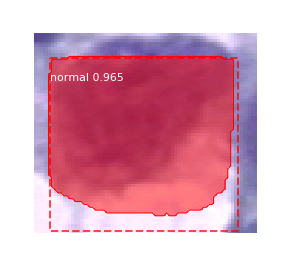

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831027-153831045-003.BMP
Processing 1 images
image                    shape: (77, 43, 3)           min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


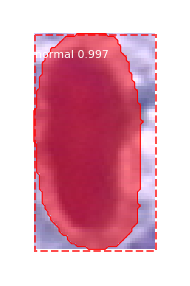

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831426-153831438-001.BMP
Processing 1 images
image                    shape: (89, 87, 3)           min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


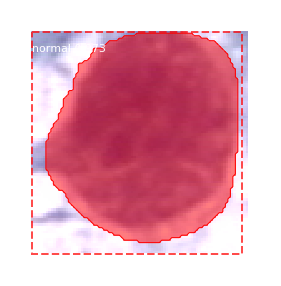

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831471-153831479-001.BMP
Processing 1 images
image                    shape: (62, 78, 3)           min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


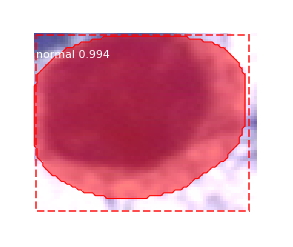

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831471-153831486-001.BMP
Processing 1 images
image                    shape: (119, 134, 3)         min:   78.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


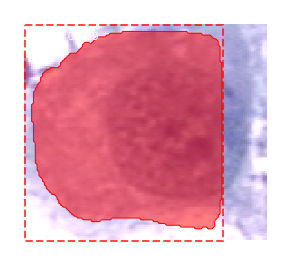

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831471-153831486-002.BMP
Processing 1 images
image                    shape: (158, 103, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


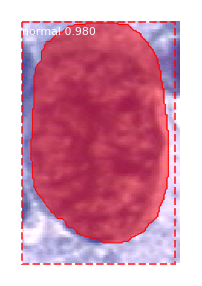

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831471-153831486-003.BMP
Processing 1 images
image                    shape: (129, 105, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


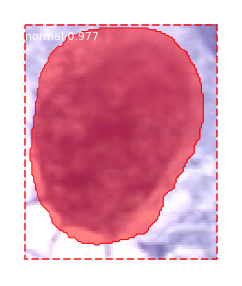

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831471-153831486-004.BMP
Processing 1 images
image                    shape: (102, 71, 3)          min:   76.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



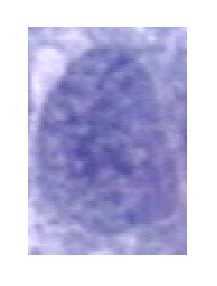

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916114-153916150-001.BMP
Processing 1 images
image                    shape: (86, 82, 3)           min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


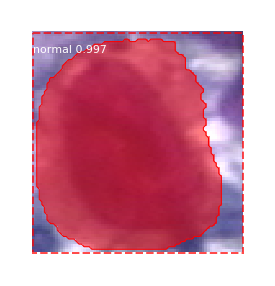

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916114-153916167-001.BMP
Processing 1 images
image                    shape: (96, 66, 3)           min:   41.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  108.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


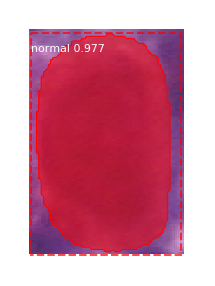

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916114-153916167-002.BMP
Processing 1 images
image                    shape: (82, 82, 3)           min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


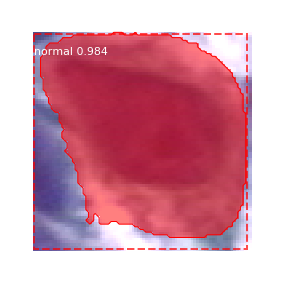

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916569-153916586-001.BMP
Processing 1 images
image                    shape: (79, 74, 3)           min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


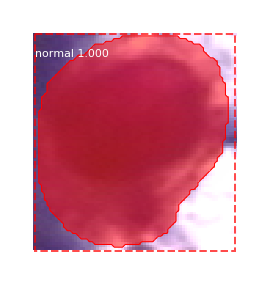

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657327-153657363-002.BMP
Processing 1 images
image                    shape: (206, 259, 3)         min:   51.00000  max:  207.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  100.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


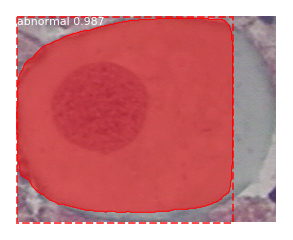

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657419-153657488-001.BMP
Processing 1 images
image                    shape: (178, 148, 3)         min:   83.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   87.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


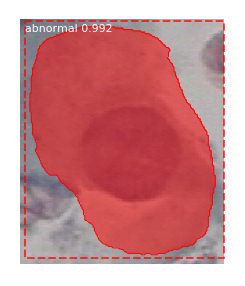

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657419-153657488-002.BMP
Processing 1 images
image                    shape: (174, 251, 3)         min:   55.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


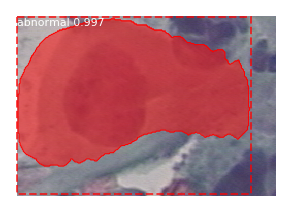

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657599-153657610-001.BMP
Processing 1 images
image                    shape: (161, 203, 3)         min:   51.00000  max:  191.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   69.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


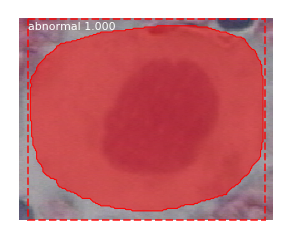

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657599-153657610-002.BMP
Processing 1 images
image                    shape: (135, 189, 3)         min:   60.00000  max:  193.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   79.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


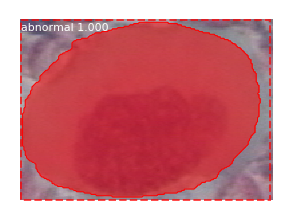

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657599-153657622-002.BMP
Processing 1 images
image                    shape: (154, 218, 3)         min:   53.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


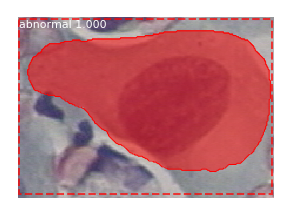

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657599-153657633-001.BMP
Processing 1 images
image                    shape: (168, 156, 3)         min:   67.00000  max:  189.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   82.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


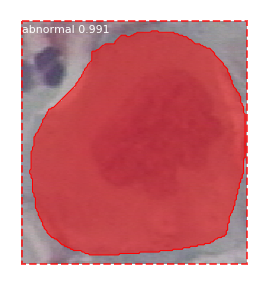

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657599-153657633-002.BMP
Processing 1 images
image                    shape: (135, 176, 3)         min:   84.00000  max:  151.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   45.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


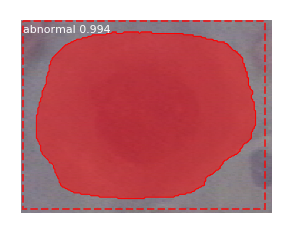

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153657698-153657708-001.BMP
Processing 1 images
image                    shape: (226, 258, 3)         min:   74.00000  max:  207.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


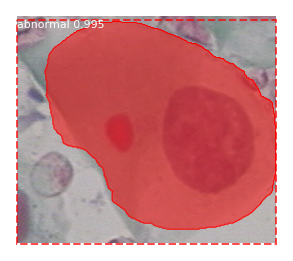

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697097-153697106-001.BMP
Processing 1 images
image                    shape: (169, 228, 3)         min:   62.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   97.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


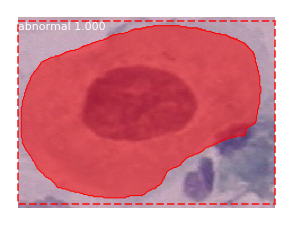

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697726-153697736-001.BMP
Processing 1 images
image                    shape: (155, 303, 3)         min:   60.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


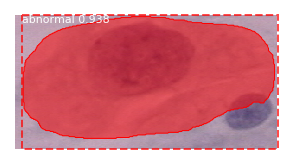

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153700207-153700215-001.BMP
Processing 1 images
image                    shape: (173, 147, 3)         min:   62.00000  max:  207.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   89.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


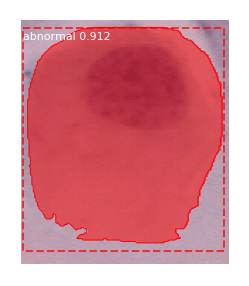

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153700207-153700224-001.BMP
Processing 1 images
image                    shape: (107, 190, 3)         min:   68.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


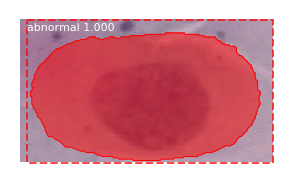

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701009-153701019-001.BMP
Processing 1 images
image                    shape: (76, 152, 3)          min:   46.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  100.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


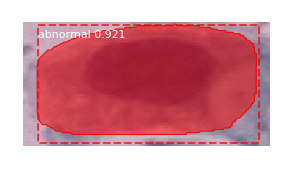

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701009-153701019-002.BMP
Processing 1 images
image                    shape: (144, 119, 3)         min:   50.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



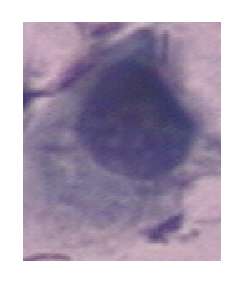

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701949-153701958-001.BMP
Processing 1 images
image                    shape: (175, 157, 3)         min:   46.00000  max:  191.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


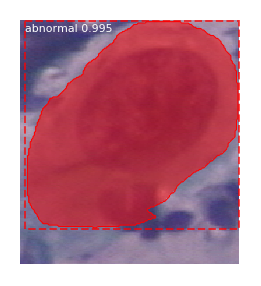

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701557-153701566-001.BMP
Processing 1 images
image                    shape: (202, 183, 3)         min:   52.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  107.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


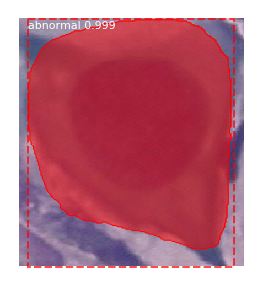

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701139-153701148-001.BMP
Processing 1 images
image                    shape: (194, 220, 3)         min:   44.00000  max:  211.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


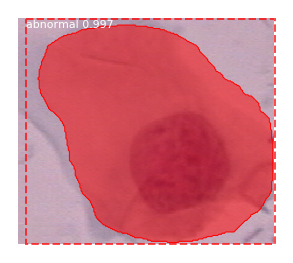

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701949-153701964-001.BMP
Processing 1 images
image                    shape: (167, 257, 3)         min:   41.00000  max:  187.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   82.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


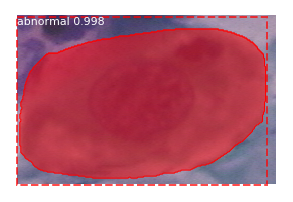

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153702037-153702051-001.BMP
Processing 1 images
image                    shape: (150, 184, 3)         min:   69.00000  max:  203.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


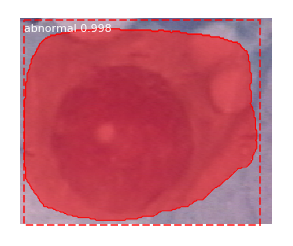

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153702037-153702051-003.BMP
Processing 1 images
image                    shape: (112, 156, 3)         min:   88.00000  max:  202.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


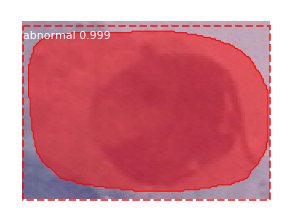

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153702037-153702051-002.BMP
Processing 1 images
image                    shape: (157, 160, 3)         min:   59.00000  max:  200.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


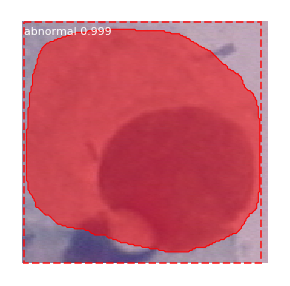

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153702037-153702060-001.BMP
Processing 1 images
image                    shape: (224, 498, 3)         min:   51.00000  max:  214.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  100.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


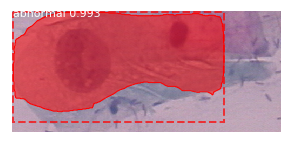

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829664-153829672-001.BMP
Processing 1 images
image                    shape: (291, 224, 3)         min:   73.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


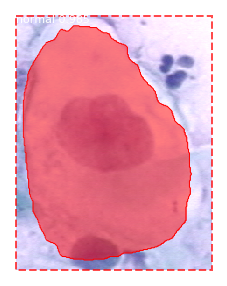

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829700-153829705-001.BMP
Processing 1 images
image                    shape: (229, 284, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


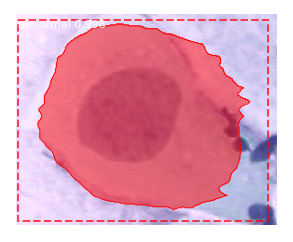

filename:/content/drive/My Drive/bin_cervic_test/abnormal/154519964-154519981-001.BMP
Processing 1 images
image                    shape: (97, 181, 3)          min:   59.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   88.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


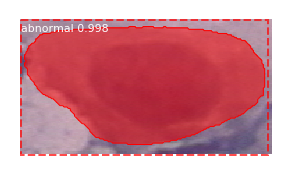

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829745-153829754-001.BMP
Processing 1 images
image                    shape: (360, 577, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  577.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


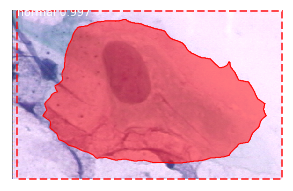

filename:/content/drive/My Drive/bin_cervic_test/abnormal/154520056-154520096-001.BMP
Processing 1 images
image                    shape: (211, 216, 3)         min:   42.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


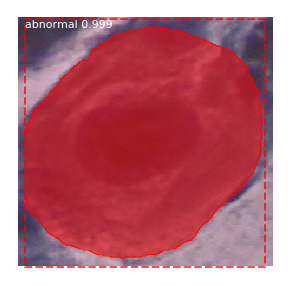

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870858-204870872-001.BMP
Processing 1 images
image                    shape: (139, 73, 3)          min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


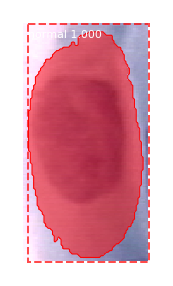

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870858-204870872-002.BMP
Processing 1 images
image                    shape: (109, 88, 3)          min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


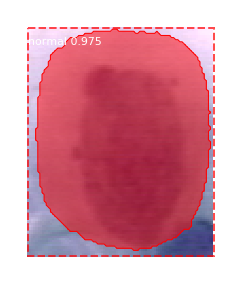

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870926-204870933-001.BMP
Processing 1 images
image                    shape: (137, 107, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


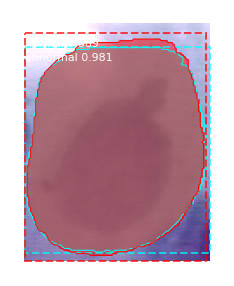

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870926-204870933-002.BMP
Processing 1 images
image                    shape: (123, 126, 3)         min:   79.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


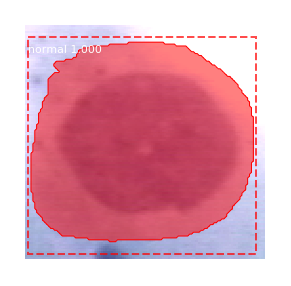

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870951-204870961-001.BMP
Processing 1 images
image                    shape: (150, 185, 3)         min:   26.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  118.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


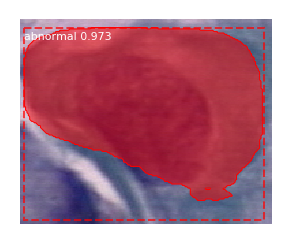

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870951-204870961-002.BMP
Processing 1 images
image                    shape: (172, 208, 3)         min:   28.00000  max:  229.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


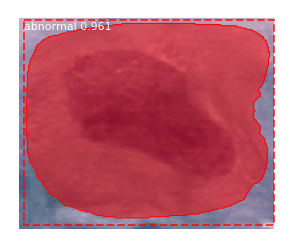

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204871030-204871038-001.BMP
Processing 1 images
image                    shape: (171, 206, 3)         min:    7.00000  max:  189.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   75.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


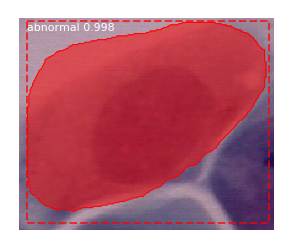

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153276386-153276405-003.BMP
Processing 1 images
image                    shape: (124, 173, 3)         min:   58.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


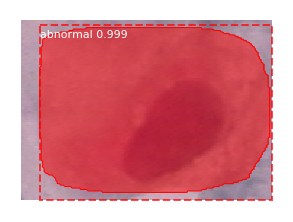

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204871030-204871038-002.BMP
Processing 1 images
image                    shape: (217, 235, 3)         min:   34.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   84.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


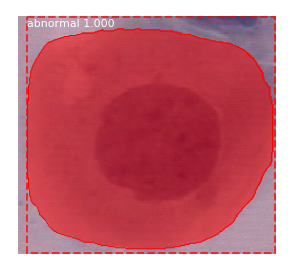

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153276386-153276405-004.BMP
Processing 1 images
image                    shape: (112, 170, 3)         min:   68.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


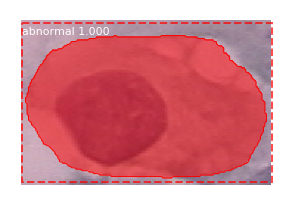

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153276386-153276414-001.BMP
Processing 1 images
image                    shape: (127, 121, 3)         min:   80.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   83.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


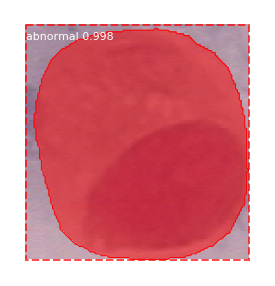

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153276799-153276818-002.BMP
Processing 1 images
image                    shape: (175, 163, 3)         min:   64.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   98.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


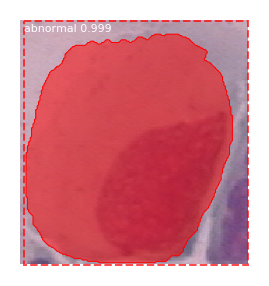

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697353-001.BMP
Processing 1 images
image                    shape: (142, 119, 3)         min:   74.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


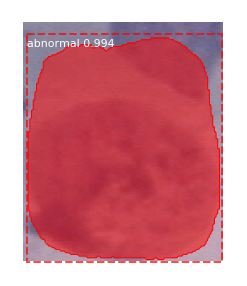

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697366-001.BMP
Processing 1 images
image                    shape: (100, 114, 3)         min:   52.00000  max:  203.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   91.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


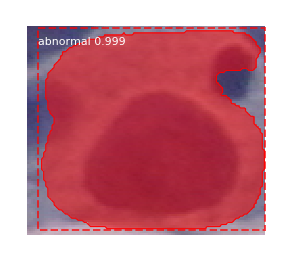

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697366-002.BMP
Processing 1 images
image                    shape: (94, 107, 3)          min:   79.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   92.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


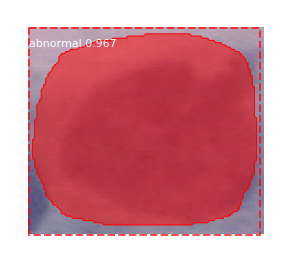

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697375-001.BMP
Processing 1 images
image                    shape: (70, 90, 3)           min:   64.00000  max:  191.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


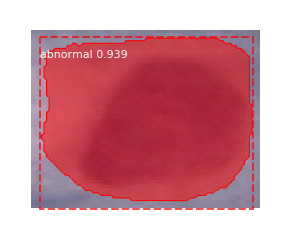

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697375-002.BMP
Processing 1 images
image                    shape: (64, 105, 3)          min:   65.00000  max:  183.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   78.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



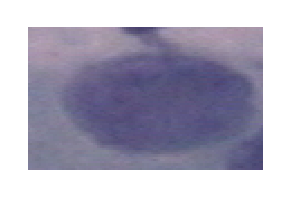

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697375-003.BMP
Processing 1 images
image                    shape: (70, 86, 3)           min:   55.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


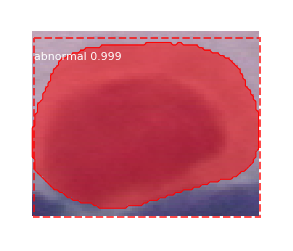

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697384-001.BMP
Processing 1 images
image                    shape: (76, 93, 3)           min:   60.00000  max:  189.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   84.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


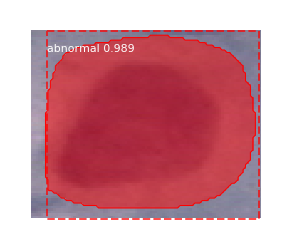

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153697342-153697384-002.BMP
Processing 1 images
image                    shape: (102, 136, 3)         min:   61.00000  max:  203.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   91.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


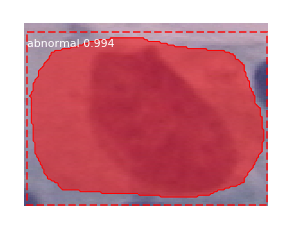

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153698259-153698268-001.BMP
Processing 1 images
image                    shape: (71, 78, 3)           min:   52.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  103.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


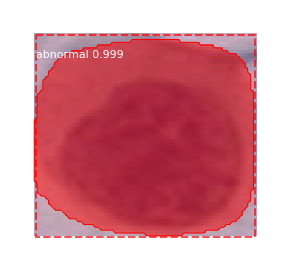

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153698259-153698268-002.BMP
Processing 1 images
image                    shape: (70, 95, 3)           min:   54.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


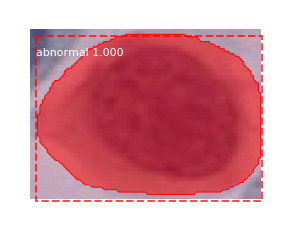

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153698259-153698268-003.BMP
Processing 1 images
image                    shape: (90, 104, 3)          min:   50.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  102.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


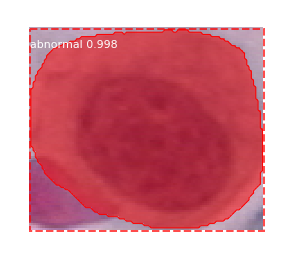

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701139-153701158-001.BMP
Processing 1 images
image                    shape: (106, 116, 3)         min:   42.00000  max:  218.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   99.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


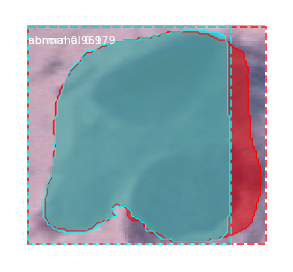

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701139-153701158-003.BMP
Processing 1 images
image                    shape: (76, 104, 3)          min:   51.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


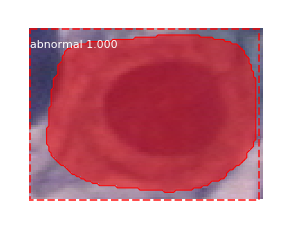

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701139-153701158-004.BMP
Processing 1 images
image                    shape: (61, 71, 3)           min:   48.00000  max:  195.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


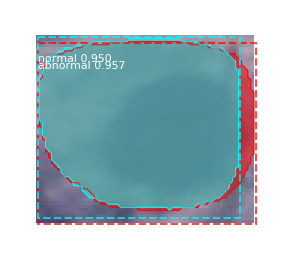

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701139-153701158-005.BMP
Processing 1 images
image                    shape: (60, 110, 3)          min:   50.00000  max:  181.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   76.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


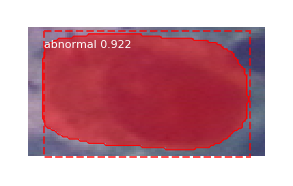

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153701622-153701650-001.BMP
Processing 1 images
image                    shape: (108, 110, 3)         min:   56.00000  max:  196.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


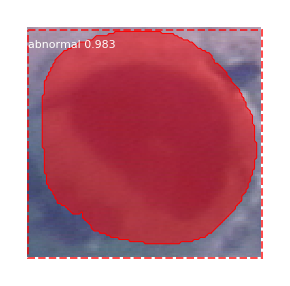

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829664-153829678-001.BMP
Processing 1 images
image                    shape: (147, 114, 3)         min:   55.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


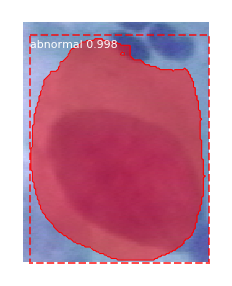

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829700-153829711-001.BMP
Processing 1 images
image                    shape: (104, 123, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


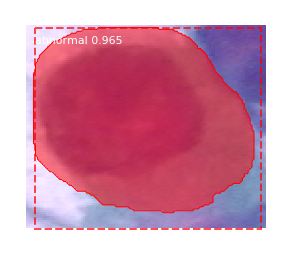

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829745-153829763-001.BMP
Processing 1 images
image                    shape: (196, 278, 3)         min:   82.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


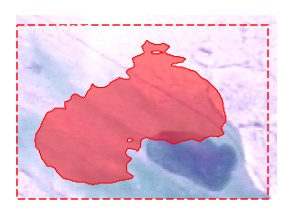

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915230-153915252-001.BMP
Processing 1 images
image                    shape: (91, 152, 3)          min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



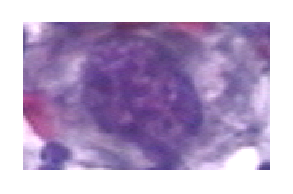

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916675-153916684-001.BMP
Processing 1 images
image                    shape: (260, 210, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


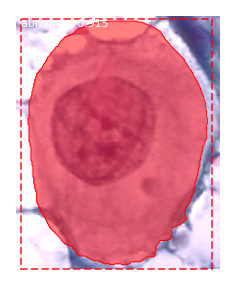

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870815-204870836-001.BMP
Processing 1 images
image                    shape: (117, 84, 3)          min:   30.00000  max:  239.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


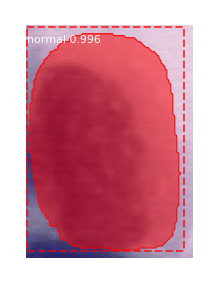

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870815-204870836-002.BMP
Processing 1 images
image                    shape: (83, 89, 3)           min:   42.00000  max:  234.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


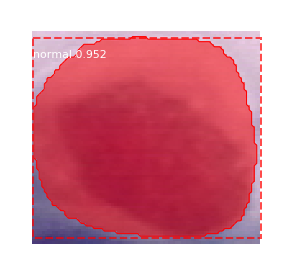

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870892-204870902-001.BMP
Processing 1 images
image                    shape: (96, 94, 3)           min:    6.00000  max:  162.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   57.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


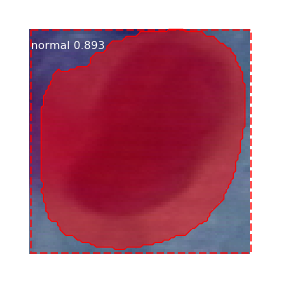

filename:/content/drive/My Drive/bin_cervic_test/abnormal/204870892-204870910-001.BMP
Processing 1 images
image                    shape: (132, 98, 3)          min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


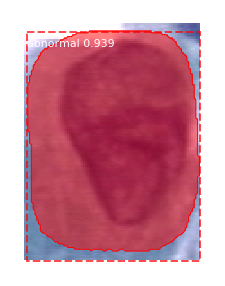

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153828970-001.BMP
Processing 1 images
image                    shape: (90, 83, 3)           min:   34.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



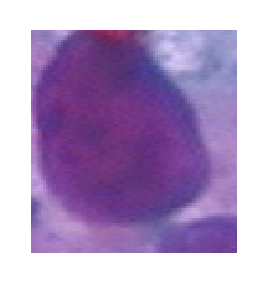

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828877-153828902-002.BMP
Processing 1 images
image                    shape: (111, 125, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


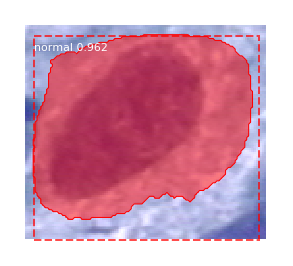

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153828980-001.BMP
Processing 1 images
image                    shape: (73, 67, 3)           min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


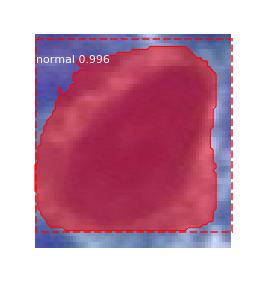

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153829000-001.BMP
Processing 1 images
image                    shape: (54, 86, 3)           min:   52.00000  max:  226.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  121.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


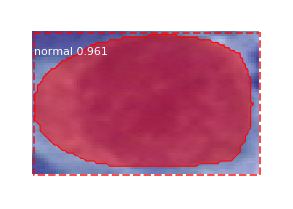

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153829000-002.BMP
Processing 1 images
image                    shape: (61, 72, 3)           min:   54.00000  max:  228.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



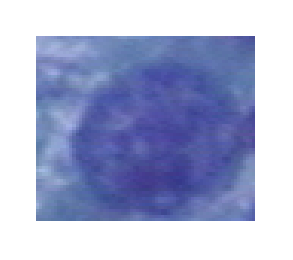

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153829000-003.BMP
Processing 1 images
image                    shape: (61, 75, 3)           min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


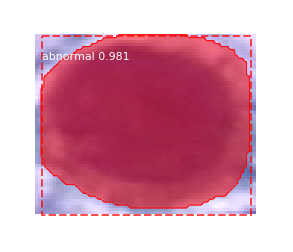

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153829005-001.BMP
Processing 1 images
image                    shape: (106, 75, 3)          min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


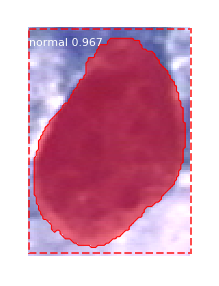

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153829005-002.BMP
Processing 1 images
image                    shape: (91, 78, 3)           min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


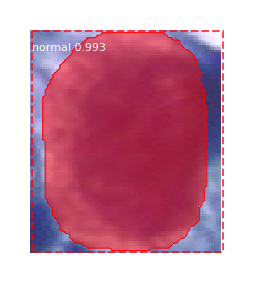

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153828952-153829009-002.BMP
Processing 1 images
image                    shape: (71, 102, 3)          min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


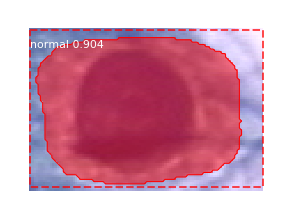

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829063-153829073-001.BMP
Processing 1 images
image                    shape: (74, 87, 3)           min:   54.00000  max:  212.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  104.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


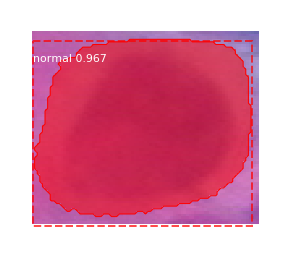

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829063-153829073-002.BMP
Processing 1 images
image                    shape: (51, 105, 3)          min:  110.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


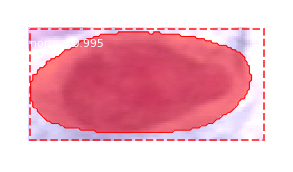

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829063-153829078-001.BMP
Processing 1 images
image                    shape: (78, 88, 3)           min:   52.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  103.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


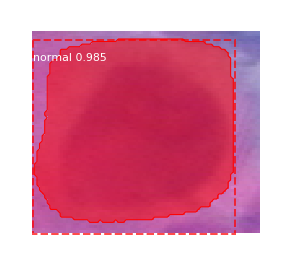

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829063-153829086-001.BMP
Processing 1 images
image                    shape: (61, 58, 3)           min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


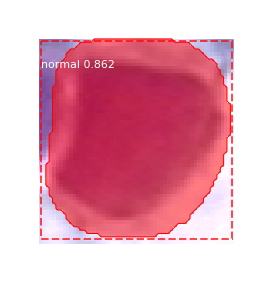

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829745-153829768-001.BMP
Processing 1 images
image                    shape: (257, 81, 3)          min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


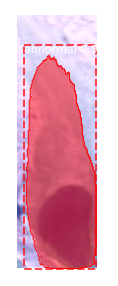

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829745-153829768-002.BMP
Processing 1 images
image                    shape: (95, 138, 3)          min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


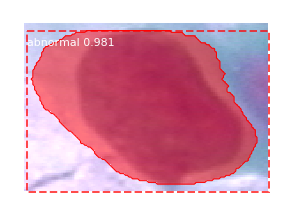

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153829745-153829768-003.BMP
Processing 1 images
image                    shape: (95, 143, 3)          min:   70.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


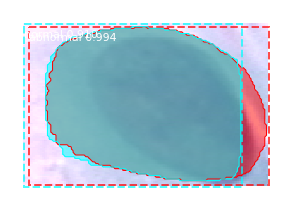

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153830261-153830340-001.BMP
Processing 1 images
image                    shape: (84, 72, 3)           min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


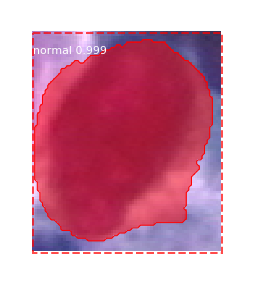

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153830261-153830340-002.BMP
Processing 1 images
image                    shape: (75, 69, 3)           min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


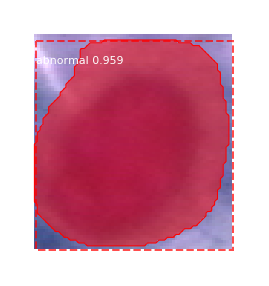

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153830680-153830827-001.BMP
Processing 1 images
image                    shape: (75, 89, 3)           min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


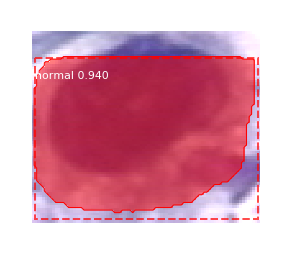

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153830680-153830827-002.BMP
Processing 1 images
image                    shape: (62, 90, 3)           min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


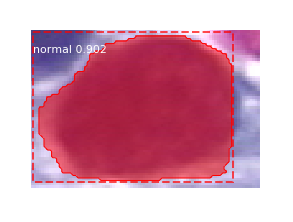

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153830680-153830827-003.BMP
Processing 1 images
image                    shape: (77, 97, 3)           min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


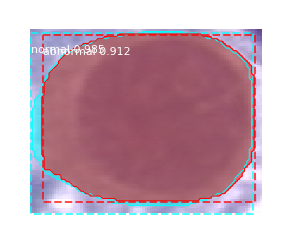

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831352-153831372-001.BMP
Processing 1 images
image                    shape: (146, 137, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


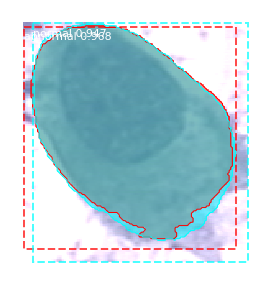

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831352-153831372-002.BMP
Processing 1 images
image                    shape: (218, 132, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


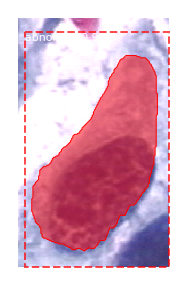

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831352-153831372-003.BMP
Processing 1 images
image                    shape: (74, 166, 3)          min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


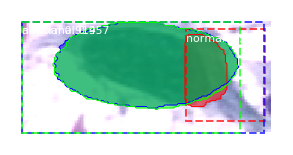

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153831352-153831372-004.BMP
Processing 1 images
image                    shape: (142, 80, 3)          min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


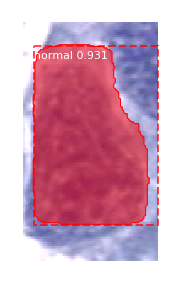

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915316-153915330-003.BMP
Processing 1 images
image                    shape: (126, 128, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


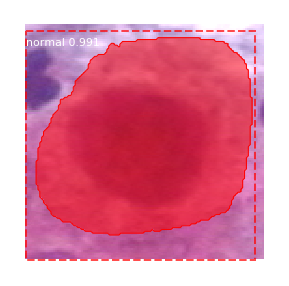

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915432-153915441-002.BMP
Processing 1 images
image                    shape: (99, 113, 3)          min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


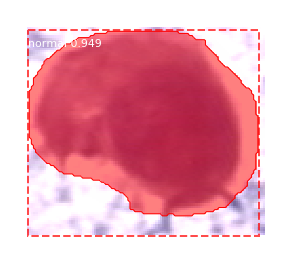

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915432-153915472-001.BMP
Processing 1 images
image                    shape: (98, 157, 3)          min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


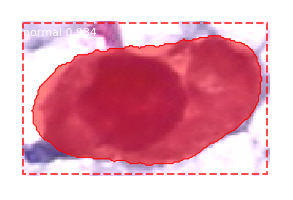

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915634-153915665-001.BMP
Processing 1 images
image                    shape: (100, 134, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


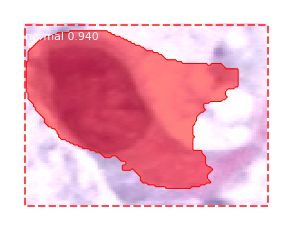

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915634-153915665-002.BMP
Processing 1 images
image                    shape: (82, 98, 3)           min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


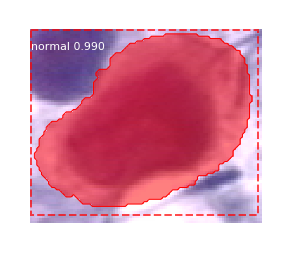

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915634-153915665-003.BMP
Processing 1 images
image                    shape: (71, 74, 3)           min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


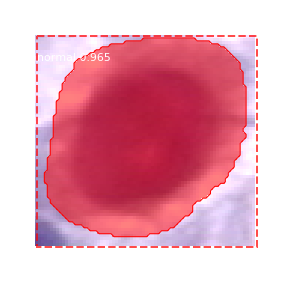

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915634-153915665-005.BMP
Processing 1 images
image                    shape: (83, 108, 3)          min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


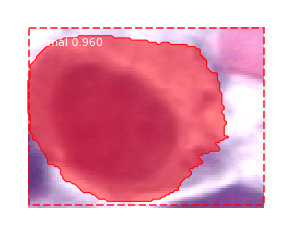

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915634-153915665-006.BMP
Processing 1 images
image                    shape: (84, 92, 3)           min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


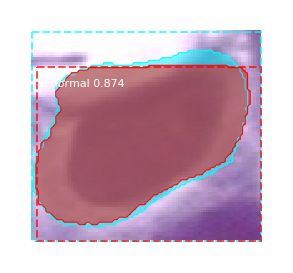

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915634-153915665-007.BMP
Processing 1 images
image                    shape: (84, 124, 3)          min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


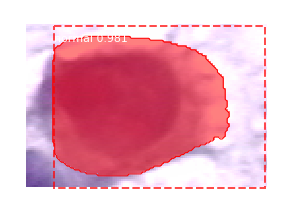

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915726-153915736-001.BMP
Processing 1 images
image                    shape: (95, 90, 3)           min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


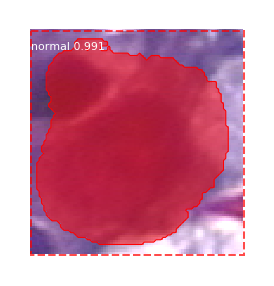

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153915726-153915774-001.BMP
Processing 1 images
image                    shape: (91, 141, 3)          min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


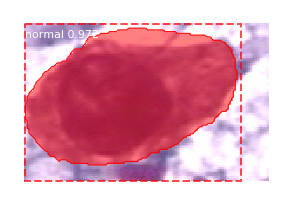

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916001-153916020-001.BMP
Processing 1 images
image                    shape: (76, 118, 3)          min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


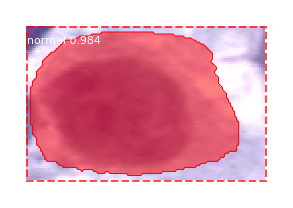

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916001-153916020-003.BMP
Processing 1 images
image                    shape: (88, 84, 3)           min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



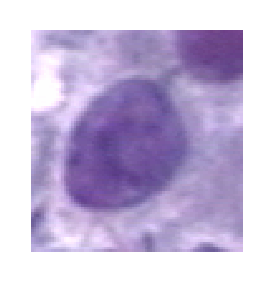

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916114-153916129-002.BMP
Processing 1 images
image                    shape: (123, 195, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


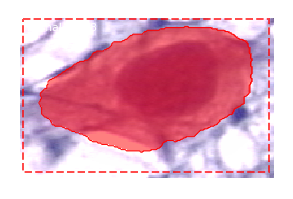

filename:/content/drive/My Drive/bin_cervic_test/abnormal/153916922-153916963-001.BMP
Processing 1 images
image                    shape: (141, 98, 3)          min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


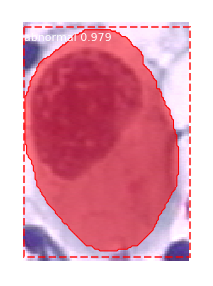

In [27]:
import skimage
real_test_dir = '/content/drive/My Drive/bin_cervic_test/abnormal'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1] in ['.png', '.jpg', '.jpeg','.BMP']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    print('filename:'+image_path)
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))